# 3-month_Prediction_acid

```
RM01/0006     503
RM01/0007     573
RM01/0004     672
RM01/0001    1507

Earliest data of Amonia: 2014-12-01
```

In [1]:
!pip install fredapi

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import preprocessor as pre
import visualiser as visual
import pandas as pd
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

In [3]:
# Import external drivers data
# Create rows and encoding
# To calculate the monthly average prices of target variable
# Create 12*N features, external factor prices from one-month before to 12-month before
# Combine features with target variables

gas_df = pre.get_Fred_data('PNGASEUUSDM',2015,2023)
wheat_df = pre.get_Fred_data('PWHEAMTUSDM',2015,2023)
ammonia_df = pre.get_Fred_data('WPU0652013A',2015,2023)
elec_df = pre.clean_elec_csv('Data_flat_files/ELECTRICITY_02_2024.csv',2015,2023)

price_evo_df = pre.clean_pred_price_evo_csv('Data_flat_files/Dataset_Predicting_Price_Evolutions_202310.csv',2017,2023)

raw_df = pre.impute_pred_price_evo_csv(price_evo_df)
dummy_df = pre.get_dummies_and_average_price(raw_df,'acid',\
                                         'RM01/0001','RM01/0004','RM01/0006','RM01/0007')

acid_df = pre.generate_features(3,14,dummy_df,\
                                PNGASEUUSDM=gas_df,\
                                PWHEAMTUSDM=wheat_df,\
                                WPU0652013A=ammonia_df,\
                                Electricity=elec_df
                               )
# print(acid_df[(acid_df['Year'] == 2016) & (acid_df['Month'] == 1)].groupby(['RM01/0004','RM01/0006','RM01/0007'])['Average_price'].mean())
# print(acid_df.info())

In [4]:
## train_test_split()
## Check data distribution
## Data scaling - log transformation and standardlisation

# Create X, y
feature_list = acid_df.drop(['Time', 'Group Description', 'Year','Month','Average_price'],axis=1)
X = feature_list.values
y = acid_df['Average_price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # 30% as test set

# Log transformation and standardlisation
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_log.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test_log.reshape(-1,1))

In [5]:
## Lasso regression - fit and transform train data set
## Cross validation and Hyperparameter tuning using RandomizedSearchCV

# Define the parameter grid
param_grid = {'alpha': np.linspace(0.0000001, 1, 3000)}

# Create a Lasso regression model
lasso = Lasso()

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=lasso, 
                                   param_distributions=param_grid, 
                                   n_iter=300, 
                                   cv=5, 
                                   random_state=42)

# Fit the data to perform a grid search
random_search.fit(X_train_scaled, y_train_scaled)

# Best alpha parameter
print("Best alpha parameter:", random_search.best_params_['alpha'])

# Best R-squared score
print("Best R-squared score:", round(random_search.best_score_, 3))

# Coefficients of the best Lasso model
assert random_search.n_features_in_ == len(feature_list.columns)
print("Coefficients of the selected features in the best Lasso model:")
for feature, coefficient in zip(feature_list.columns, random_search.best_estimator_.coef_):
    print(f"{feature}: {round(coefficient,3)}")

Best alpha parameter: 0.02234087802600867
Best R-squared score: 0.893
Coefficients of the selected features in the best Lasso model:
RM01/0004: -0.003
RM01/0006: 0.27
RM01/0007: -0.663
PNGASEUUSDM_3: 0.14
PWHEAMTUSDM_3: 0.305
WPU0652013A_3: 0.084
Electricity_3: 0.0
PNGASEUUSDM_4: 0.0
PWHEAMTUSDM_4: 0.0
WPU0652013A_4: 0.0
Electricity_4: 0.0
PNGASEUUSDM_5: 0.0
PWHEAMTUSDM_5: 0.01
WPU0652013A_5: 0.0
Electricity_5: 0.0
PNGASEUUSDM_6: 0.031
PWHEAMTUSDM_6: 0.0
WPU0652013A_6: 0.0
Electricity_6: 0.0
PNGASEUUSDM_7: 0.0
PWHEAMTUSDM_7: 0.0
WPU0652013A_7: 0.0
Electricity_7: -0.0
PNGASEUUSDM_8: 0.0
PWHEAMTUSDM_8: 0.0
WPU0652013A_8: 0.0
Electricity_8: 0.0
PNGASEUUSDM_9: 0.0
PWHEAMTUSDM_9: 0.0
WPU0652013A_9: 0.0
Electricity_9: 0.0
PNGASEUUSDM_10: 0.0
PWHEAMTUSDM_10: 0.0
WPU0652013A_10: 0.0
Electricity_10: 0.0
PNGASEUUSDM_11: 0.0
PWHEAMTUSDM_11: 0.0
WPU0652013A_11: -0.0
Electricity_11: 0.0
PNGASEUUSDM_12: 0.0
PWHEAMTUSDM_12: 0.0
WPU0652013A_12: 0.0
Electricity_12: 0.0
PNGASEUUSDM_13: 0.0
PWHEAMTUSDM_1

In [6]:
## Lasso regression - transform test data set

# Get the best Lasso model from RandomizedSearchCV
best_lasso_model = random_search.best_estimator_

# Predict on the test data
y_pred_test = best_lasso_model.predict(X_test_scaled)
y_pred_test_inverse = np.exp(scaler_y.inverse_transform(y_pred_test.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y

# Evaluate the model performance on the test data
test_score = best_lasso_model.score(X_test_scaled, y_test_scaled)
print("Best Model:", best_lasso_model)
print("Test Set R-squared score:", round(test_score, 3))

# Calculate MAPE
print("MAPE: ", round(mean_absolute_percentage_error(y_test,y_pred_test_inverse), 3))

# Best mean_squared_error
print("Mean_Squared_Error: ", round(mean_squared_error(y_test,y_pred_test_inverse), 3))

Best Model: Lasso(alpha=0.02234087802600867)
Test Set R-squared score: 0.925
MAPE:  0.145
Mean_Squared_Error:  0.047


In [7]:
## Lasso regression - transform new data and match the predicted values with real values
# Get latest data

gas_df = pre.get_Fred_data('PNGASEUUSDM',2015,2024)
wheat_df = pre.get_Fred_data('PWHEAMTUSDM',2015,2024)
ammonia_df = pre.get_Fred_data('WPU0652013A',2015,2024)

price_evo_df_24 = pre.clean_pred_price_evo_csv('Data_flat_files/Dataset_Future_Predicting_Price_Evolutions_202403.csv',2017,2024)


raw_df_24 = pre.impute_pred_price_evo_csv(price_evo_df_24)

dummy_df_24 = pre.get_dummies_and_average_price(raw_df_24,'acid',\
                                         'RM01/0001','RM01/0004','RM01/0006','RM01/0007')

acid_df_24 = pre.generate_features(3,14,dummy_df_24,\
                                   PNGASEUUSDM=gas_df,\
                                   PWHEAMTUSDM=wheat_df,\
                                   WPU0652013A=ammonia_df,\
                                   Electricity=elec_df)

# Create X, y
feature_list = acid_df_24.drop(['Time', 'Group Description','Year','Month','Average_price'],\
                                  axis=1)
X_24 = feature_list.values
y_24 = acid_df_24['Average_price'].values

# Log transformation and standardlisation
X_scaled_24 = scaler_x.transform(X_24)

# Predict new y
y_pred_24 = best_lasso_model.predict(X_scaled_24)
y_pred_24_inverse = np.exp(scaler_y.inverse_transform(y_pred_24.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y

# Calculate MAPE
mape_24 = mean_absolute_percentage_error(y_24,y_pred_24_inverse)
print(f'MAPE: {mape_24:.3f}')

# Best mean_squared_error
print("Mean_Squared_Error: ", round(mean_squared_error(y_24,y_pred_24_inverse), 3))


# To match the predicted values with original df
acid_df_24['Predictions'] = y_pred_24_inverse

acid_df_24['year_month'] = acid_df_24['Year'].apply(round).astype('str') + "-" + acid_df_24['Month'].apply(round).astype('str')

MAPE: 0.150
Mean_Squared_Error:  0.035


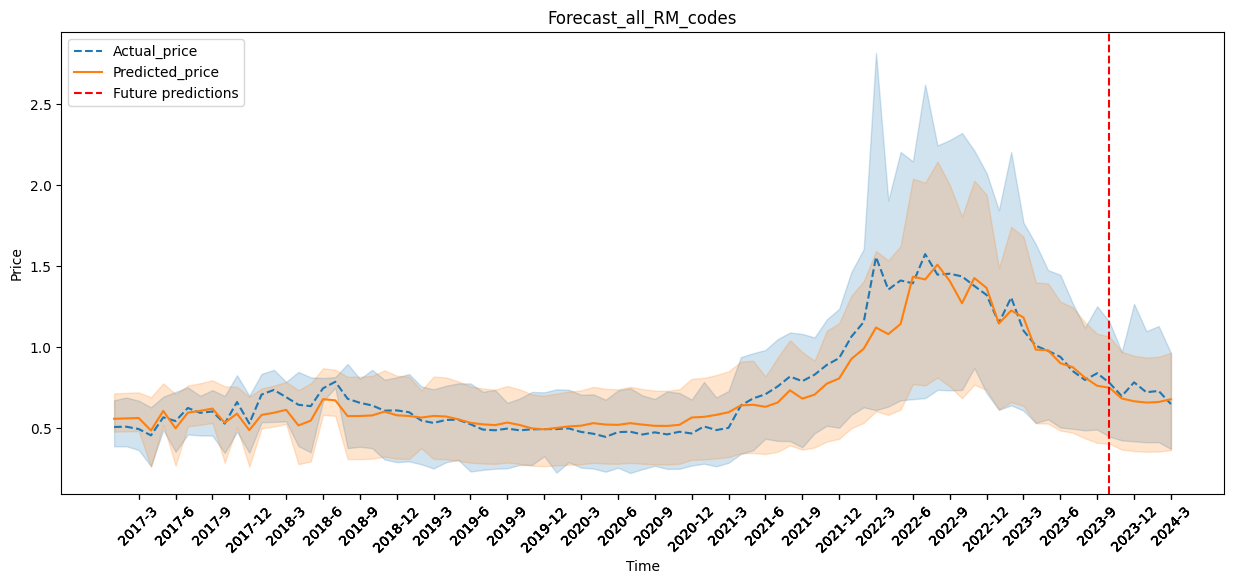

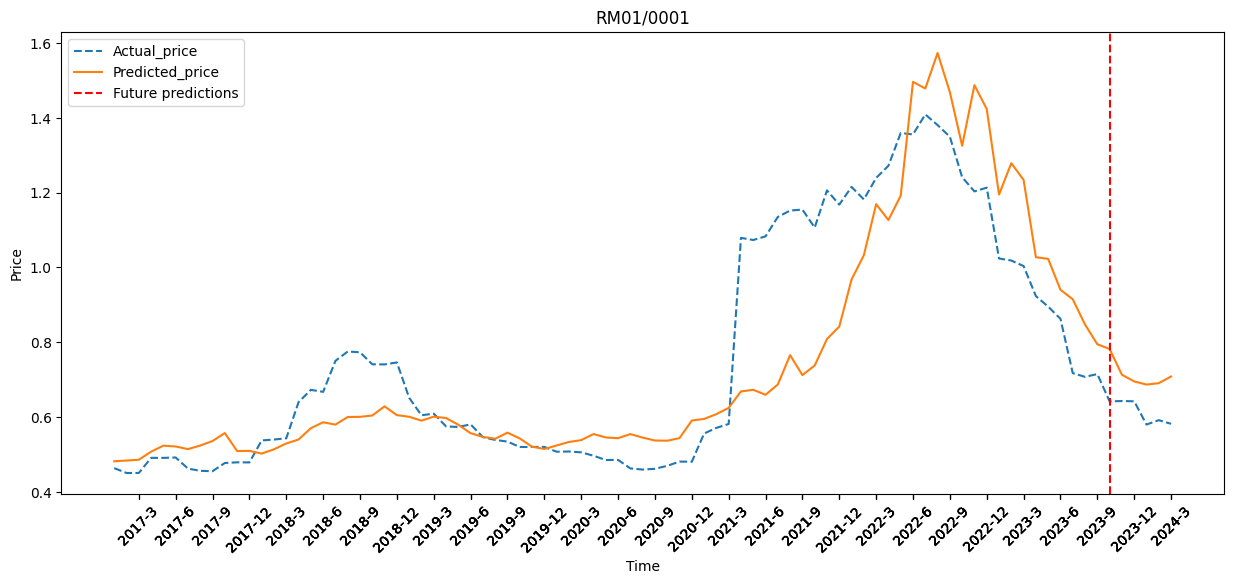

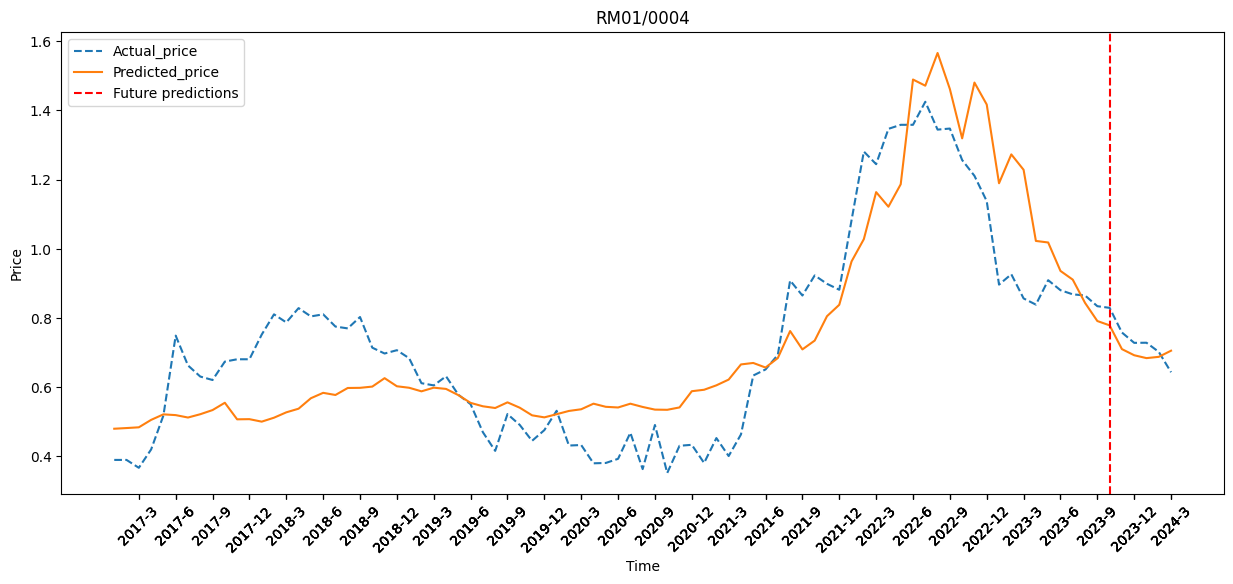

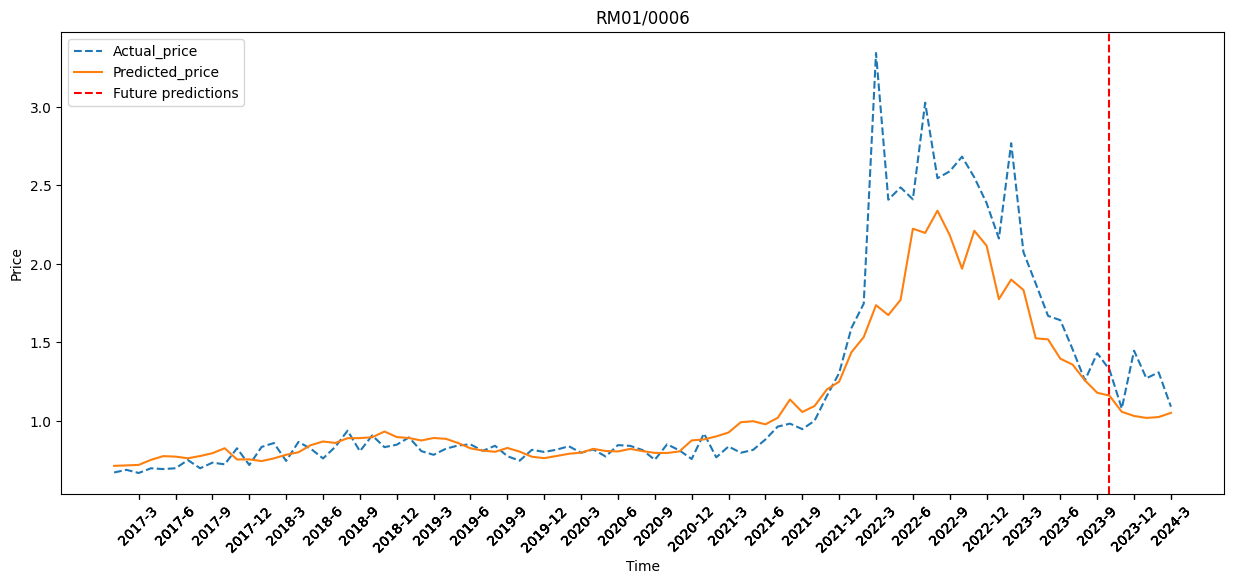

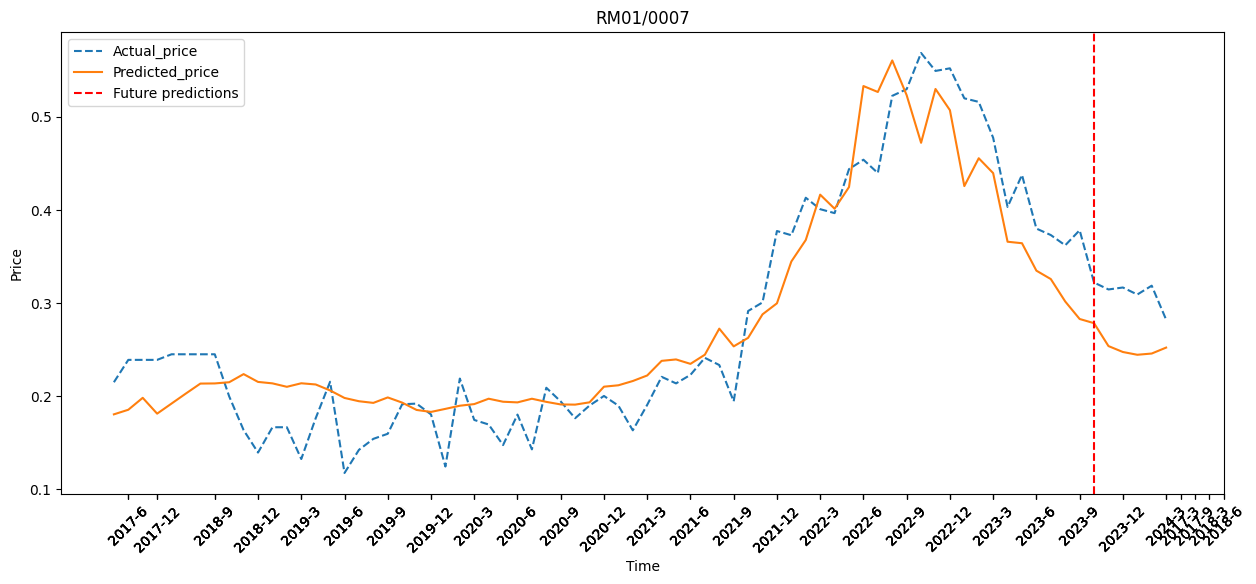

In [8]:
## Visualisation
visual.draw_graph(acid_df_24,'year_month','Average_price','Predictions','2023-10','RM01/0001', 'RM01/0004', 'RM01/0006', 'RM01/0007')